## [Fitting a Bayesian Factor Analysis Model in Stan](https://rfarouni.github.io/assets/projects/BayesianFactorAnalysis/BayesianFactorAnalysis.html)

### [Cholesky factors of covariance matrices](https://mc-stan.org/docs/reference-manual/cholesky-factors-of-covariance-matrices-1.html)

### [Cholesky factors of covariance and correlation matrices in Stan](https://yingqijing.medium.com/cholesky-factors-of-covariance-and-correlation-matrices-in-stan-37a302d11690)

A Cholesky factor of a covariance matrix requires $N + (N/2) + (M−N)N$ unconstrained parameters.

$$y^T=(y_1,y_2, ..., y_p)$$
$$y=\Lambda \theta + \epsilon$$

$$\Lambda=
\begin{bmatrix}
\lambda_{1,1} & \lambda_{1,2} & \dots & \lambda_{1,D}\\
\lambda_{2,1} & \lambda_{2,2} & \dots & \lambda_{2,D}\\
\vdots & \vdots & \vdots & \vdots\\
\lambda_{p,1} & \lambda_{p,2} & \dots & \lambda_{p,D}\\
\end{bmatrix}$$

$$\Phi_D = 
\begin{bmatrix}
1 & \varphi_{1,2} & \dots & \varphi_{1,D}\\
\varphi_{2,1} & 1 & \dots & \varphi_{2,D}\\
\vdots & \vdots & \vdots & \vdots\\
\varphi_{D,1} & \dots &\varphi_{D,D-1} & 1\\
\end{bmatrix}$$

$$\Psi_P = 
\begin{bmatrix}
\psi_1 & 0 & \dots & 0\\
0 & \psi_2 & \dots & 0\\
\vdots & \vdots & \vdots & \vdots\\
0 & \dots &0 & \psi_P\\
\end{bmatrix}$$

$$y\sim Normaal_P(0, \Lambda\Phi\Lambda^T+\Psi)$$

$$p(\Theta,\Lambda,\tilde{\xi},\Phi|Y)\propto \left[ \prod _{i=1}^N p(y_i|\theta_i,\Lambda)\right] \left[ \prod _{i=1}^{N} p(\theta_i|\Phi) \right]p(\Lambda|\tilde{\xi})p(\Phi)p(\tilde{\xi})$$

N D-dimensional latent vectors $\Theta=(\theta_1. \theta_2, \dots, theta_i, \dots, \theta_N)$
$$p(\Lambda,\tilde{\xi},\Phi|Y)\propto \left[ \prod _{i=1}^N \int_{R_\theta} p(y_i|\theta_i,\Lambda) p(\theta_i|\Phi) d\theta \right]p(\Lambda|\tilde{\xi})p(\Phi)p(\tilde{\xi})$$

$y_i$ is a P-dimensional vector of responses for respondent i

### orthogonal rotation matrix T, where $T^TT=I$ and $\lambda T^TT\theta=\Lambda\theta$

### Simulating Data

In [ ]:
library(MASS)

In [ ]:
D <- 3
P <- 10
N <- 300

In [ ]:
mu_theta = rep(0, D)
mu_epsilon = rep(0, P)

In [ ]:
Phi <- diag(rep(1,D))
Psi <- diag(c(0.2079, 0.19, 0.1525, 0.20, 0.36, 0.1875, 0.1875, 1.00, 0.27, 0.27))

In [ ]:
l1 <- c(0.99, 0.00, 0.25, 0.00, 0.80, 0.00, 0.50, 0.00, 0.00, 0.00)
l2 <- c(0.00, 0.90, 0.25, 0.40, 0.00, 0.50, 0.00, 0.00, -0.30, -0.30)
l3<-  c(0.00, 0.00, 0.85, 0.80, 0.00, 0.75, 0.75, 0.00, 0.80, 0.80)
L = cbind(l1,l2,l3)

In [ ]:
Theta <- mvrnorm(N, mu_theta, Phi)

In [ ]:
Epsilon <- mvrnorm(N, mu_epsilon, Psi)

In [ ]:
Y <- Theta %*% t(L) + Epsilon

In [ ]:
dim(Y)

In [ ]:
dl_fa <- list(
    N = N,
    P = P,
    D = D,
    Y = Y
)

In [ ]:
saveRDS(dl_fa, file = 'factor_data_list.rds')

### Visualization

In [ ]:
library(rbokeh)

In [ ]:
df <- data.frame(Y)

In [ ]:
names(df)[1:P]

In [ ]:
tools <- c("pan", "wheel_zoom", "resize", "reset")

In [ ]:
nms <- expand.grid(names(df)[1:P], rev(names(df)[1:P]), stringsAsFactors = FALSE)

In [ ]:
nms$Var2[1]

In [ ]:
nms$yaxis <- rep(c(TRUE, rep(FALSE, P-1)), P)
nms$xaxis <- c(rep(FALSE, (P-1)*P), rep(TRUE, P))

In [ ]:
nms$h <- nms$w <- 75
nms$h[nms$xaxis] <- nms$w[nms$yaxis] <- 90

In [ ]:
library(ggplot2)
library(gridExtra)

In [ ]:
plot_uni_scatter <- function(df, nms, i){
    return( ggplot(data = df, aes(x = get(nms$Var1[i]), y = get(nms$Var2[i]))) + geom_point(color='blue') +
    xlab(nms$Var1[i]) + ylab(nms$Var2[i]) + theme(axis.text = element_text(size=2), axis.title = element_text(size=3)) )
}

In [ ]:
plot_uni_scatter(df, nms, 2)

In [ ]:
plot_list <- vector('list', P^2)

In [ ]:
for (i in seq_along(plot_list)){
    #message(i)
    p <-ggplotGrob(plot_uni_scatter(df, nms, i))
    plot_list[[i]] <- p
}

In [ ]:
grid.arrange(grobs = plot_list, ncol = 10)

## Estimation

In [ ]:
library(dplyr)
library(rstan)
library(bayesplot)
library(Metrics)
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

In [ ]:
remove(model)
model = stan_model('../RStan/Models/factor_mvn.stan')

In [ ]:
remove(fit)
fit <- sampling(object = model,
                data = dl_fa,
                init = "random",
                control = list(adapt_delta = 0.95),
                chains = 4,
                iter = 888,
                warmup = 555,
                thin = 1,
                verbose = TRUE)

In [ ]:
summary(fit)

In [36]:
names(fit)

[1] "L_t[1]"    "L_t[2]"    "L_t[3]"    "L_t[4]"    "L_t[5]"    "L_t[6]"   
  [7] "L_t[7]"    "L_t[8]"    "L_t[9]"    "L_t[10]"   "L_t[11]"   "L_t[12]"  
 [13] "L_t[13]"   "L_t[14]"   "L_t[15]"   "L_t[16]"   "L_t[17]"   "L_t[18]"  
 [19] "L_t[19]"   "L_t[20]"   "L_t[21]"   "L_t[22]"   "L_t[23]"   "L_t[24]"  
 [25] "L_d[1]"    "L_d[2]"    "L_d[3]"    "psi[1]"    "psi[2]"    "psi[3]"   
 [31] "psi[4]"    "psi[5]"    "psi[6]"    "psi[7]"    "psi[8]"    "psi[9]"   
 [37] "psi[10]"   "mu_psi"    "sigma_psi" "mu_lt"     "sigma_lt"  "L[1,1]"   
 [43] "L[2,1]"    "L[3,1]"    "L[4,1]"    "L[5,1]"    "L[6,1]"    "L[7,1]"   
 [49] "L[8,1]"    "L[9,1]"    "L[10,1]"   "L[1,2]"    "L[2,2]"    "L[3,2]"   
 [55] "L[4,2]"    "L[5,2]"    "L[6,2]"    "L[7,2]"    "L[8,2]"    "L[9,2]"   
 [61] "L[10,2]"   "L[1,3]"    "L[2,3]"    "L[3,3]"    "L[4,3]"    "L[5,3]"   
 [67] "L[6,3]"    "L[7,3]"    "L[8,3]"    "L[9,3]"    "L[10,3]"   "Q[1,1]"   
 [73] "Q[2,1]"    "Q[3,1]"    "Q[4,1]"    "Q[5,1]"    "Q[6,1]"    "Q[7,1]"   
 [79] "Q[8,1]"    "Q[9,1]"    "Q[10,1]"   "Q[1,2]"    "Q[2,2]"    "Q[3,2]"   
 [85] "Q[4,2]"    "Q[5,2]"    "Q[6,2]"    "Q[7,2]"    "Q[8,2]"    "Q[9,2]"   
 [91] "Q[10,2]"   "Q[1,3]"    "Q[2,3]"    "Q[3,3]"    "Q[4,3]"    "Q[5,3]"   
 [97] "Q[6,3]"    "Q[7,3]"    "Q[8,3]"    "Q[9,3]"    "Q[10,3]"   "Q[1,4]"   
[103] "Q[2,4]"    "Q[3,4]"    "Q[4,4]"    "Q[5,4]"    "Q[6,4]"    "Q[7,4]"   
[109] "Q[8,4]"    "Q[9,4]"    "Q[10,4]"   "Q[1,5]"    "Q[2,5]"    "Q[3,5]"   
[115] "Q[4,5]"    "Q[5,5]"    "Q[6,5]"    "Q[7,5]"    "Q[8,5]"    "Q[9,5]"   
[121] "Q[10,5]"   "Q[1,6]"    "Q[2,6]"    "Q[3,6]"    "Q[4,6]"    "Q[5,6]"   
[127] "Q[6,6]"    "Q[7,6]"    "Q[8,6]"    "Q[9,6]"    "Q[10,6]"   "Q[1,7]"   
[133] "Q[2,7]"    "Q[3,7]"    "Q[4,7]"    "Q[5,7]"    "Q[6,7]"    "Q[7,7]"   
[139] "Q[8,7]"    "Q[9,7]"    "Q[10,7]"   "Q[1,8]"    "Q[2,8]"    "Q[3,8]"   
[145] "Q[4,8]"    "Q[5,8]"    "Q[6,8]"    "Q[7,8]"    "Q[8,8]"    "Q[9,8]"   
[151] "Q[10,8]"   "Q[1,9]"    "Q[2,9]"    "Q[3,9]"    "Q[4,9]"    "Q[5,9]"   
[157] "Q[6,9]"    "Q[7,9]"    "Q[8,9]"    "Q[9,9]"    "Q[10,9]"   "Q[1,10]"  
[163] "Q[2,10]"   "Q[3,10]"   "Q[4,10]"   "Q[5,10]"   "Q[6,10]"   "Q[7,10]"  
[169] "Q[8,10]"   "Q[9,10]"   "Q[10,10]"  "lp__"

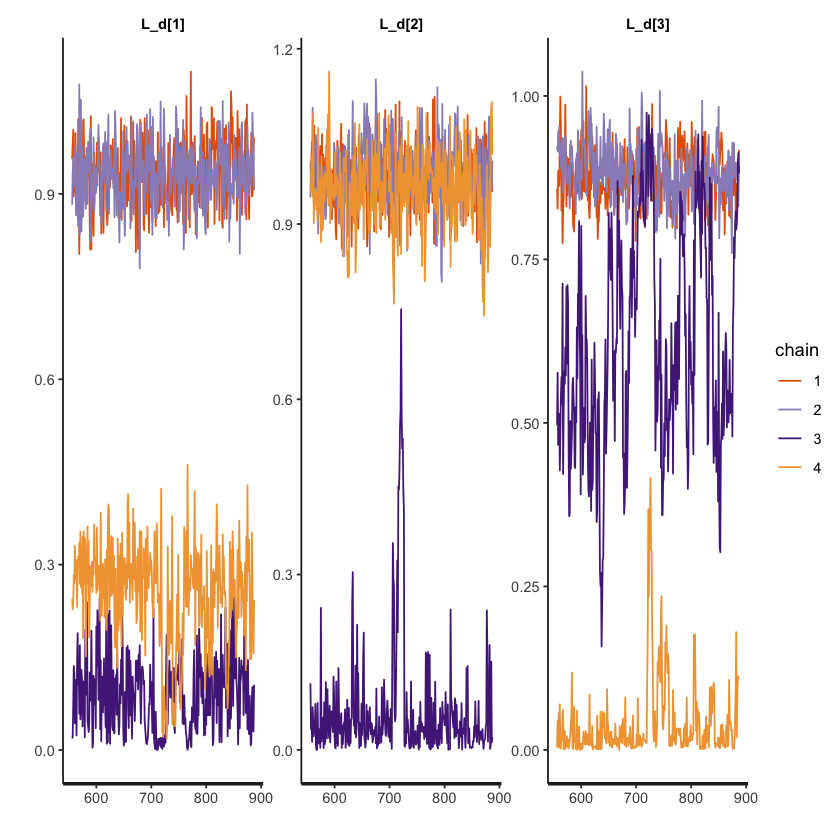

In [35]:
traceplot(fit, pars=c("L_d"))

In [37]:
theme_Posterior = theme(
  axis.line.x = element_line(arrow=arrow(length=unit(0.05, "cm")), lineend = "butt"),
  panel.background = element_rect(fill="transparent"), 
  panel.border = element_rect(fill="transparent"),
  plot.background = element_rect(fill = "transparent"),
  #panel.spacing.y = unit(1,"lines"),
  plot.margin = unit(c(1,1,1,1), "cm"), 
  #
  axis.title.y = element_blank(), 
  axis.text.y = element_text(color = "grey20", size = 8, angle = 0, hjust = 1, vjust = 0, face = "plain"),
  axis.text.x = element_text(color="grey20",hjust=1, vjust=1, size=8, angle=50, face="plain"), 
  axis.ticks.y = element_blank()
)

ci_level: 0.9 (90% intervals)

outer_level: 0.95 (95% intervals)



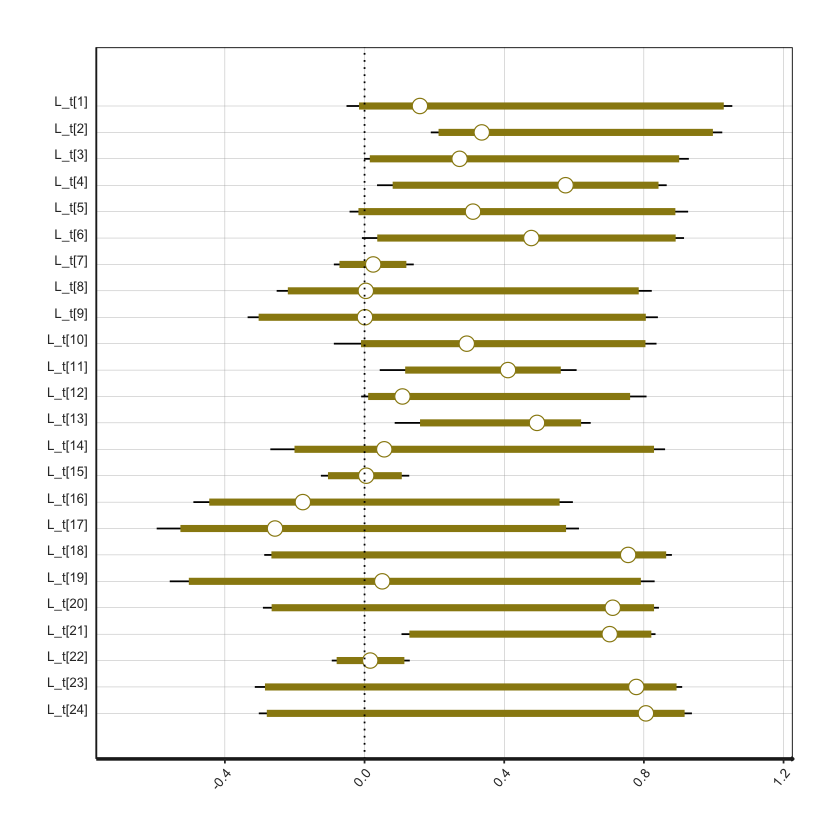

In [38]:
plot(fit,
     pars = names(fit)[c(1:24)],
     show_density = FALSE,
     fill_color = "#998811",
     est_color = "#ffffff",
     ci_level = 0.9, outer_level=0.95) +
  geom_vline(xintercept = 0, linetype = 3, linewidth = 0.5) + 
  theme_Posterior